# Setup and Libraries

In [26]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and parse Imaging Protocol

In [27]:
CSV_DIR = ROOT_DIR / "csv_dir"
original_df = pd.read_csv(CSV_DIR / "PPMI_all.csv")

# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)

print(original_df.columns)

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

print(original_df.columns)

Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Research Group', 'Visit',
       'Study Date', 'Archive Date', 'Age', 'GDSCALE Total Score', 'Modality',
       'Description', 'Type', 'Imaging Protocol', 'Image ID', 'Structure',
       'Laterality', 'Image Type', 'Registration', 'Tissue'],
      dtype='object')
Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Research Group', 'Visit',
       'Study Date', 'Archive Date', 'Age', 'GDSCALE Total Score', 'Modality',
       'Description', 'Type', 'Imaging Protocol', 'Image ID', 'Structure',
       'Laterality', 'Image Type', 'Registration', 'Tissue',
       'Acquisition Plane', 'Slice Thickness', 'Matrix Z', 'Acquisition Type',
       'Manufacturer', 'Mfg Model', 'Field Strength', 'Weighting'],
      dtype='object')


# Filters

In [28]:
# Apply filters
df = original_df[
    (original_df["Modality"] == "MRI")
    & (
        (original_df["Weighting"] == "T1")
        | (original_df["Description"].str.contains("T1", case=False, na=False))
    )
    & (original_df["Matrix Z"] >= 100)
    # & (original_df["Slice Thickness"] <= 1.4)
    & (original_df["Acquisition Type"] == "3D")
].copy()
print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)
# display(sorted(df["Description"].dropna().unique()))

Filtered dataset size: 5745 images from 3097 subjects.


# Basic descriptions

In [29]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]

# print(f"Columns with missing values ({len(cols_with_missing)}):\n")
# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Sex
3,Weight
4,Research Group
5,Visit
6,Study Date
7,Archive Date
8,Age
9,GDSCALE Total Score



=== Numeric Features Summary ===


,Weight,Age,GDSCALE Total Score,Slice Thickness,Matrix Z,Field Strength
count,5740.00,5745.00,3915.00,5745.00,5745.00,5745.00
mean,80.47,65.21,2.11,1.04,185.34,2.84
std,20.94,8.58,2.58,0.22,19.22,0.46
min,37.50,30.40,0.00,0.90,100.00,0.70
25%,69.00,60.80,0.00,1.00,176.00,3.00
50%,79.30,65.90,1.00,1.00,192.00,3.00
75%,90.00,71.00,3.00,1.00,192.00,3.00
max,1000.00,87.40,15.00,12.00,384.00,3.00



=== Categorical Features Summary ===


,Subject ID,Project,Sex,Research Group,Visit,Study Date,Archive Date,Modality,Description,Type,...,Structure,Laterality,Image Type,Registration,Tissue,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,5745,5745,5745,5745,5745,5745,5745,5745,5745,5745,...,5745,5745,2257,5745,5745,5745,5745,5745,5740,5745
unique,3097,1,2,5,12,2017,357,1,116,1,...,1,1,1,1,1,4,1,11,31,2
top,72826,PPMI,M,Prodromal,Baseline,12/06/2023,1/25/2024,MRI,3D T1-weighted,Original,...,Brain,Both,image volume,native,All,SAGITTAL,3D,SIEMENS,Prisma_fit,T1
freq,9,5745,3233,2829,3470,16,146,5745,1254,5745,...,5745,5745,2257,5745,5745,5657,5745,4076,1089,3507



=== Missing Values by Column ===


,Missing Count,Missing %
Image Type,3488,60.71
GDSCALE Total Score,1830,31.85
Mfg Model,5,0.09
Weight,5,0.09
Sex,0,0.00
Research Group,0,0.00
Study Date,0,0.00
Visit,0,0.00
Archive Date,0,0.00
Age,0,0.00


# Histograms

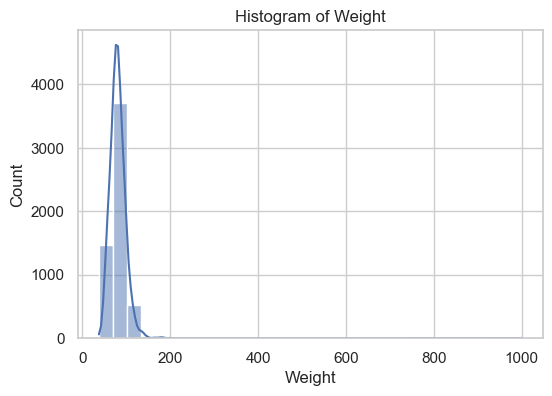

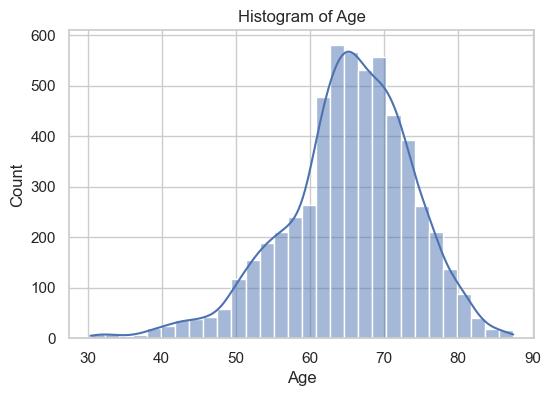

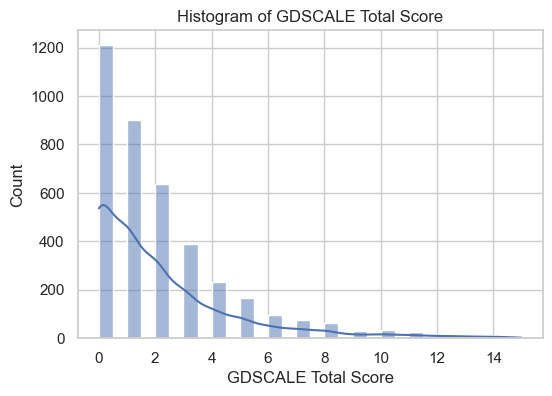

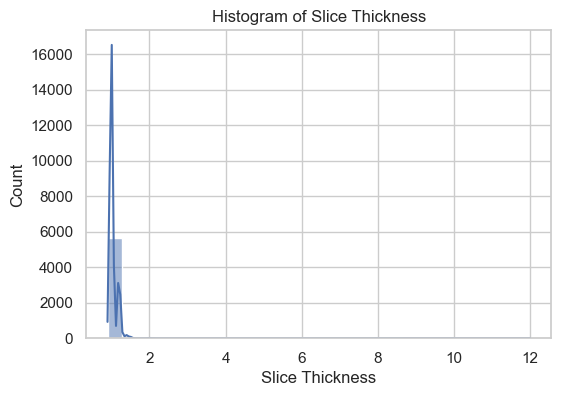

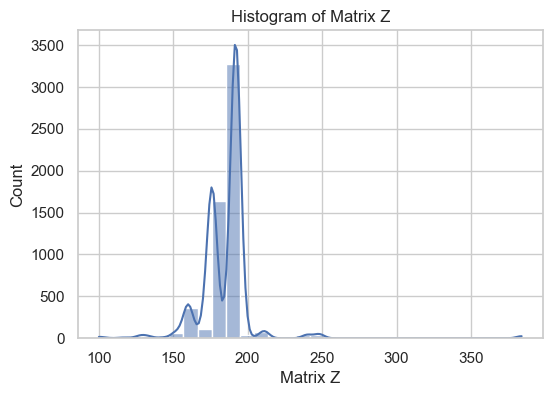

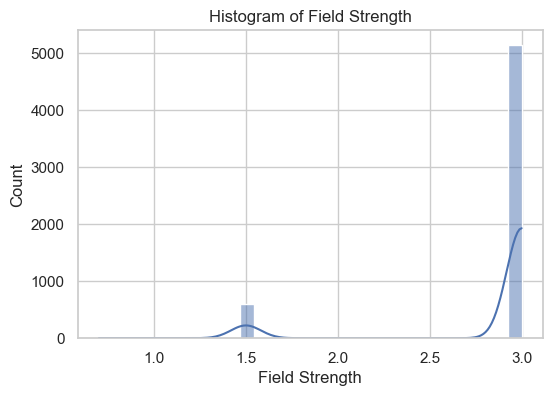

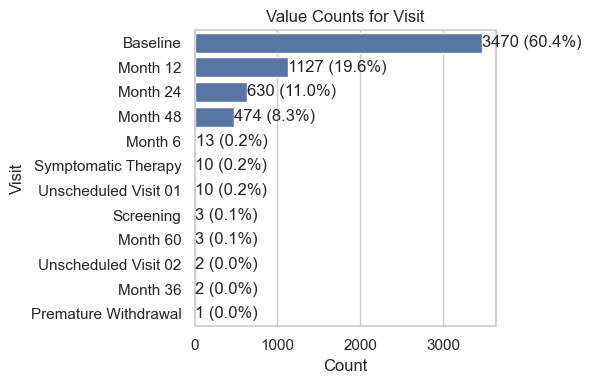

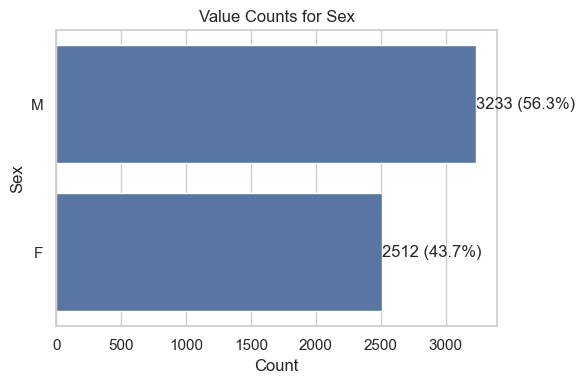

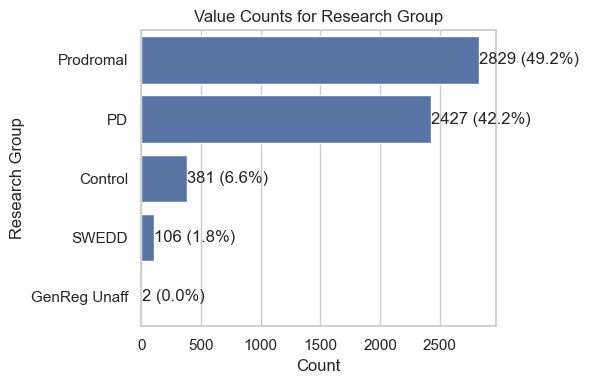

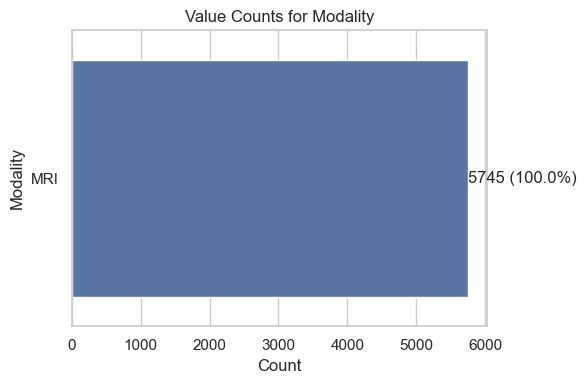

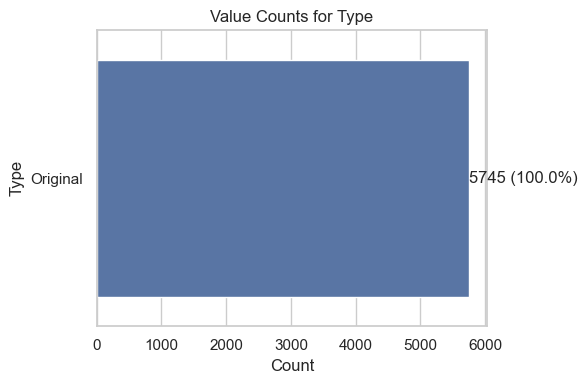

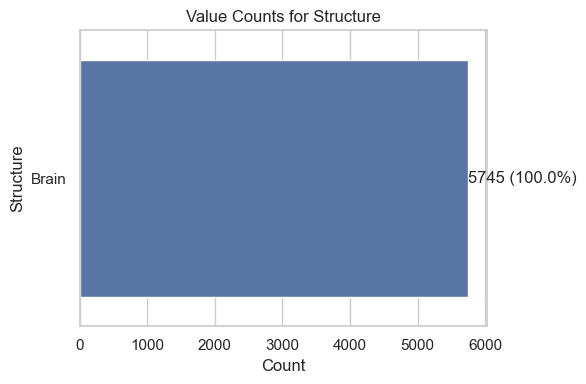

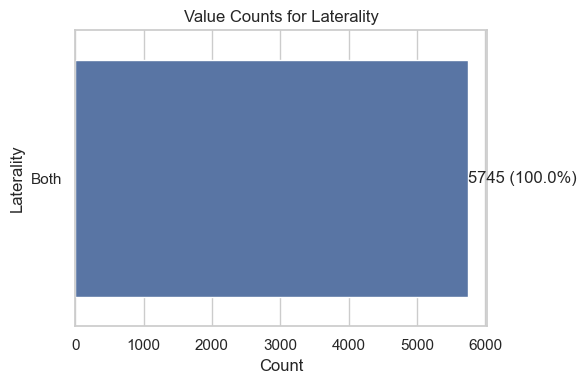

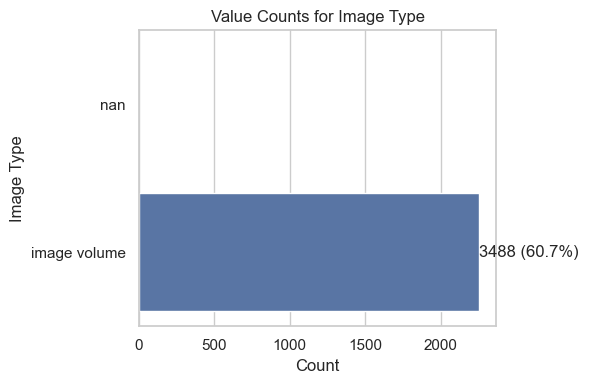

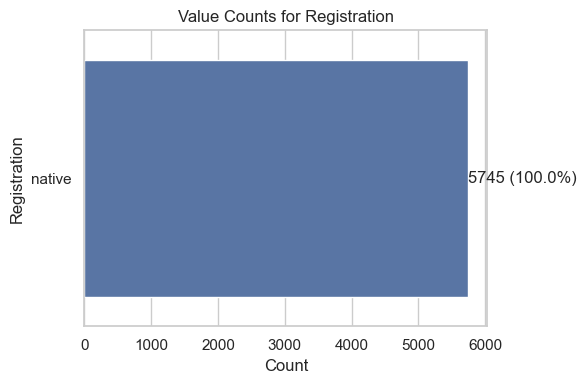

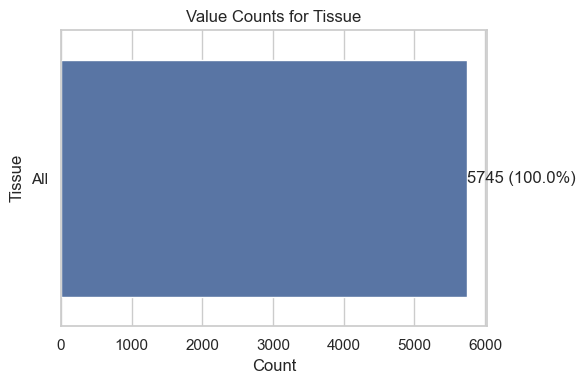

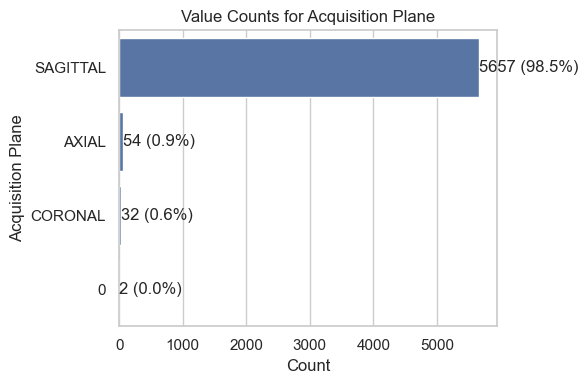

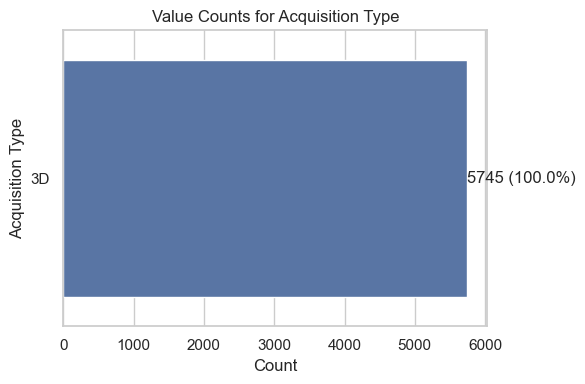

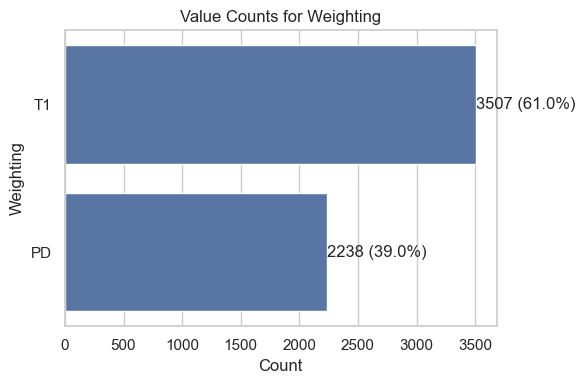

In [30]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)  # dropna to ignore missing
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Tissue",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Longitudinal analysis - for filtered subset

In [31]:
df["Visit"].unique()

array(['Baseline', 'Month 24', 'Month 48', 'Month 12', 'Month 6',
       'Symptomatic Therapy', 'Unscheduled Visit 02',
       'Unscheduled Visit 01', 'Screening', 'Month 36',
       'Premature Withdrawal', 'Month 60'], dtype=object)

In [32]:
import re
import numpy as np

visit_values = df["Visit"].unique()

scheduled_visits = {}
event_visits = []

for v in visit_values:
    v_clean = str(v).strip()

    if v_clean.lower() == "baseline":
        scheduled_visits[v_clean] = 0
    elif re.match(r"Month\s*(\d+)", v_clean, re.IGNORECASE):
        month_num = int(re.match(r"Month\s*(\d+)", v_clean, re.IGNORECASE).group(1))
        scheduled_visits[v_clean] = month_num
    else:
        event_visits.append(v_clean)

print("Scheduled Visits:", scheduled_visits)
print("Event Visits:", event_visits)


Scheduled Visits: {'Baseline': 0, 'Month 24': 24, 'Month 48': 48, 'Month 12': 12, 'Month 6': 6, 'Month 36': 36, 'Month 60': 60}
Event Visits: ['Symptomatic Therapy', 'Unscheduled Visit 02', 'Unscheduled Visit 01', 'Screening', 'Premature Withdrawal']


Longitudinal Coverage per Subject (Scheduled Visits):


/tmp/ipykernel_197886/1750573419.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scheduled_df.groupby("Subject ID")["Visit_Months"]


count    3831.000000
mean        1.295223
std         0.971003
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: Visit_Months, dtype: float64

/tmp/ipykernel_197886/1750573419.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


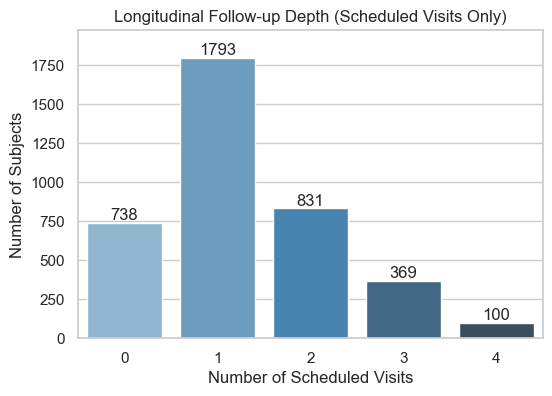

In [33]:
# Map scheduled visits to months and define visit type
df["Visit_Months"] = df["Visit"].map(scheduled_visits)
df["Visit_Type"] = np.where(
    df["Visit"].isin(scheduled_visits.keys()), "Scheduled", "Event"
)

# Keep only scheduled visits
scheduled_df = df[df["Visit_Type"] == "Scheduled"].copy()

# Count unique scheduled visits per subject
visits_per_subject = (
    scheduled_df.groupby("Subject ID")["Visit_Months"]
    .nunique()
    .sort_values(ascending=False)
)

# Summary statistics
summary_stats = visits_per_subject.describe()
print("Longitudinal Coverage per Subject (Scheduled Visits):")
display(summary_stats)

# -------------------------------
# Plot barplot with counts on top
# -------------------------------
# Count how many subjects have each number of visits
visit_counts = visits_per_subject.value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

# Annotate each bar with the count
for i, v in enumerate(visit_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.xlabel("Number of Scheduled Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth (Scheduled Visits Only)")
plt.xticks(range(len(visit_counts.index)), visit_counts.index)
plt.ylim(0, visit_counts.values.max() * 1.1)  # Add some space for annotations
plt.show()


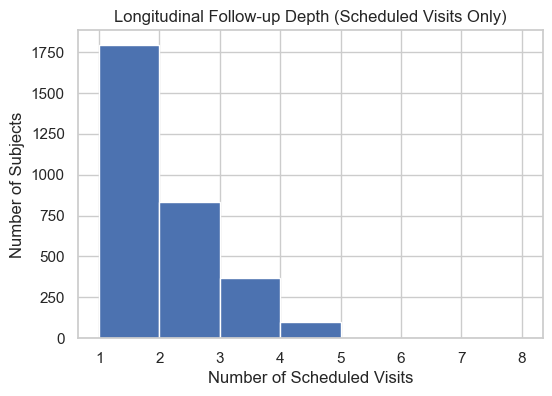

In [34]:
plt.figure(figsize=(6, 4))
plt.hist(visits_per_subject, bins=range(1, 9))
plt.xlabel("Number of Scheduled Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth (Scheduled Visits Only)")
plt.show()


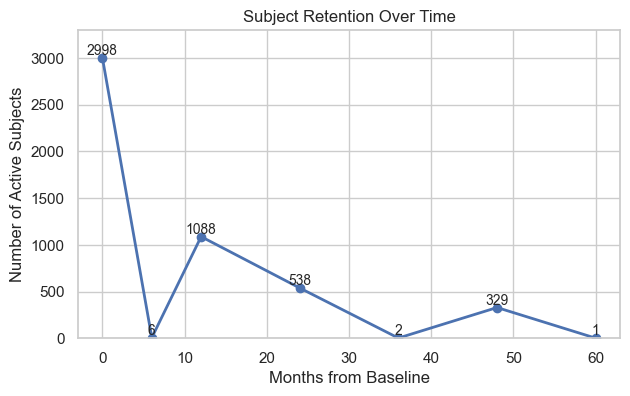

/tmp/ipykernel_197886/490767801.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")


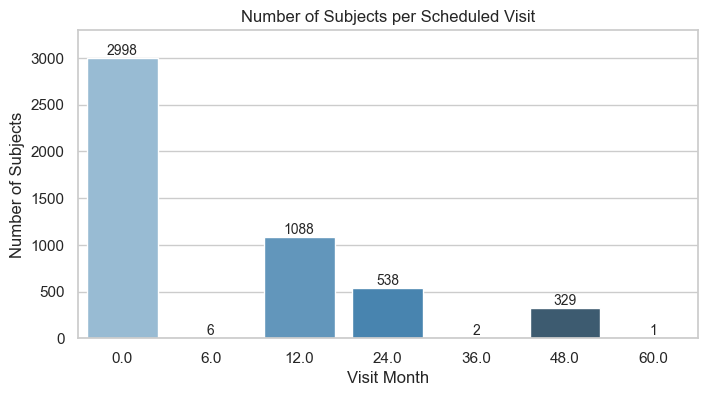

In [ ]:
# Compute retention
retention = scheduled_df.groupby("Visit_Months")["Subject ID"].nunique().sort_index()

# -----------------------------
# Line plot with exact numbers
# -----------------------------
plt.figure(figsize=(7, 4))
plt.plot(retention.index, retention.values, marker="o", linewidth=2)

# Annotate each point with the exact number
for x, y in zip(retention.index, retention.values):
    plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=10)

plt.xlabel("Months from Baseline")
plt.ylabel("Number of Active Subjects")
plt.title("Subject Retention Over Time")
plt.grid(True)
plt.ylim(0, retention.values.max() * 1.1)
plt.show()

# -----------------------------
# Bar plot with exact numbers
# -----------------------------
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")

# Annotate each bar with the exact number
for i, v in enumerate(retention.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

plt.xlabel("Visit Month")
plt.ylabel("Number of Subjects")
plt.title("Number of Subjects per Scheduled Visit")
plt.ylim(0, retention.values.max() * 1.1)
plt.show()

/tmp/ipykernel_197886/2236856767.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  scheduled_df.groupby(["Subject ID", "Visit_Months"]).size().unstack(fill_value=0)


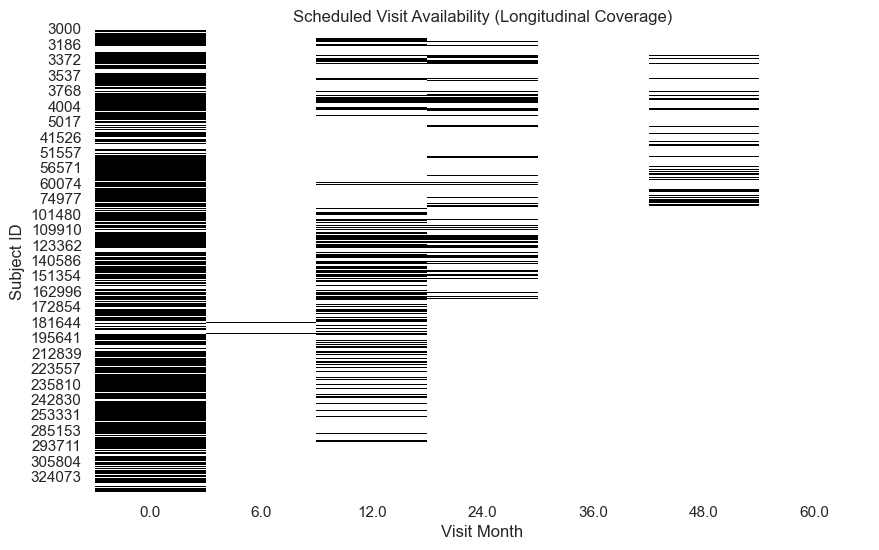

In [36]:
coverage = (
    scheduled_df.groupby(["Subject ID", "Visit_Months"]).size().unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(coverage > 0, cmap="Greys", cbar=False)
plt.xlabel("Visit Month")
plt.ylabel("Subject ID")
plt.title("Scheduled Visit Availability (Longitudinal Coverage)")
plt.show()
